In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from gym import envs
#print(envs.registry.all())

In [3]:
import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

#from rl.agents.dqn import DQNAgent
from rl.agents import SARSAAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy, MaxBoltzmannQPolicy, BoltzmannGumbelQPolicy
from rl.memory import SequentialMemory

import os

Using TensorFlow backend.


In [4]:
path = os.path.join( os.getcwd(), '..' )
model_save_path = path + '/Model Archive/'
results_save_path = path + '/Results/'

In [5]:
print(path)
print(model_save_path)
print(results_save_path)

/Users/Aswin_Shriram_T/Documents/Northeastern University/Semester 1/Foundations of AI CS5100/Project/Project_Files/FAI Project/DSARSA_LLD/Code/..
/Users/Aswin_Shriram_T/Documents/Northeastern University/Semester 1/Foundations of AI CS5100/Project/Project_Files/FAI Project/DSARSA_LLD/Code/../Model Archive/
/Users/Aswin_Shriram_T/Documents/Northeastern University/Semester 1/Foundations of AI CS5100/Project/Project_Files/FAI Project/DSARSA_LLD/Code/../Results/


In [6]:
ENV_NAME = 'LunarLander-v2'

In [ ]:
# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

In [ ]:
# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

In [ ]:
# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
# memory = SequentialMemory(limit=500000, window_length=1)
# policy = BoltzmannQPolicy()
# policy = EpsGreedyQPolicy()
policy = MaxBoltzmannQPolicy()
#Q_sarsa = SARSAAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
#               target_model_update=1e-2, policy=policy)

Q_sarsa = SARSAAgent(model = model, nb_actions=nb_actions, policy=policy, nb_steps_warmup=100)

Q_sarsa.compile(Adam(lr=1e-3), metrics=['mae', 'mse'])

#Q_qlearning = Q_learning(env, lr=.1, num_episodes=5000, eps=0.4, gamma=0.95, eps_decay=0.001)

#Q_sarsaQ_sarsa = SARSA(env, lr=.1, num_episodes=5000, eps=0.4, gamma=0.95, eps_decay=0.001)


In [ ]:
from rl import callbacks

In [ ]:
# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
Q_sarsa.fit(env, nb_steps=50000, action_repetition=1, visualize=False, callbacks=[callbacks.FileLogger(results_save_path+'dqn_{}_weights.txt'.format(ENV_NAME))], verbose=1)

In [ ]:
# Q_sarsa After training is done, we save the final weights.
Q_sarsa.save_weights('dsarsa_{}_weights.h5'.format(ENV_NAME), overwrite=True)

In [ ]:
# Q_sarsa Finally, evaluate our algorithm for 5 episodes.
# Q_sarsa.test(env, nb_episodes=5, visualize=True)

In [ ]:
Q_sarsa.load_weights(model_save_path + 'dsarsa_{}_weights.h5'.format(ENV_NAME))

In [ ]:
# Finally, evaluate our algorithm for 5 episodes.
Q_sarsa.test(env, nb_episodes=10, visualize=False)

In [ ]:
# Finally, evaluate our algorithm for 5 episodes.
Q_sarsa.test(env, nb_episodes=5, visualize=True)

In [ ]:
env.close()

In [ ]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder

In [ ]:
def video_saver(filename, agent=Q_sarsa, env=env, num_epi=5, path_save = results_save_path+'Videos/'):
    rec = VideoRecorder(env, path = path_save+filename, enabled=True)
    rec.capture_frame()
    for i_episode in range(num_epi):
        rec.capture_frame()
        observation = env.reset()
        for t in range(1000):
            env.render()
            #print(observation)
            #action = agent.actor.predict(observation.reshape(1,1,env.observation_space.shape[0]))
            action = agent.model.predict(observation.reshape(1,1,env.observation_space.shape[0]))
            #print(action)
            observation, reward, done, info = env.step(np.argmax(action))
            rec.capture_frame()
            if done:
                print("Episode finished after {} timesteps".format(t+1))
                print("Reward at the end of episode {} :".format(i_episode+1), reward)
                break
    rec.close()
    env.close()

In [ ]:
video_saver('dsarsa_{}_results_test.mp4'.format(ENV_NAME))

In [ ]:
# Finally, evaluate our algorithm for 5 episodes.
history = Q_sarsa.test(env, nb_episodes=100, verbose = 2, visualize=False)

In [7]:
import pandas as pd

In [ ]:
# pd.DataFrame(history.history).to_csv(results_save_path + 'dsarsa_{}_results_test.csv'.format(ENV_NAME))

In [8]:
import json

In [9]:
import matplotlib.pyplot as plt

In [10]:
plt.rcParams['figure.figsize'] = 15, 10

In [11]:
model_results = json.load(open(results_save_path+'dsarsa_{}_weights.txt'.format(ENV_NAME)))

In [12]:
type(model_results)

dict

In [14]:
model_results_df = pd.DataFrame(model_results)
analyze_df = model_results_df.copy()
analyze_df['episode'] +=1
analyze_df['avg_reward_per_episode-step'] = analyze_df['episode_reward']/analyze_df['nb_episode_steps']

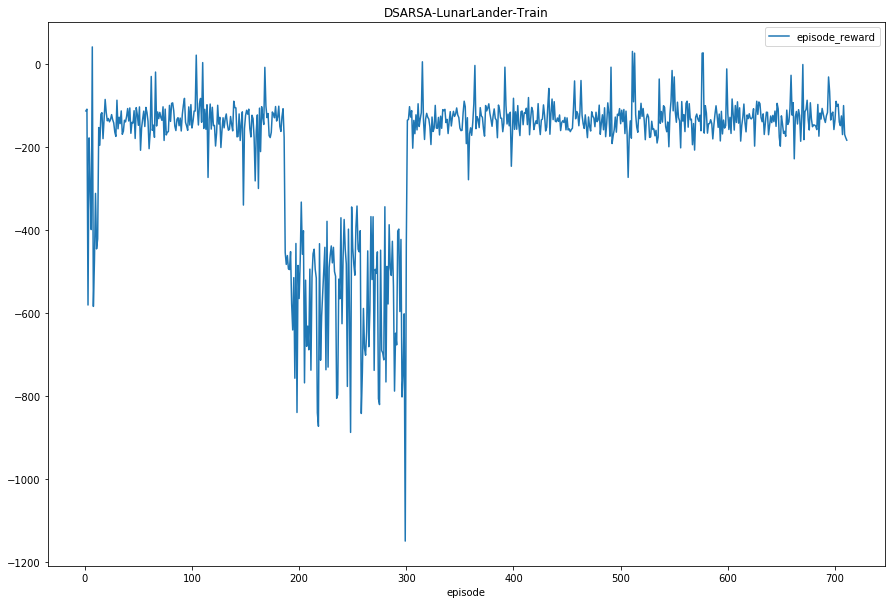

In [15]:
analyze_df.set_index(['episode'])[['episode_reward']].plot()
plt.title('DSARSA-LunarLander-Train')
plt.savefig(results_save_path+'train_rewards.png', dpi=400, bbox_inches='tight')

In [16]:
test_df = pd.read_csv(results_save_path+'dsarsa_{}_results_test.csv'.format(ENV_NAME))
test_df['Unnamed: 0'] +=1
test_df.columns = ['episode', 'episode_reward', 'nb_steps']

In [17]:
test_df.columns

Index(['episode', 'episode_reward', 'nb_steps'], dtype='object')

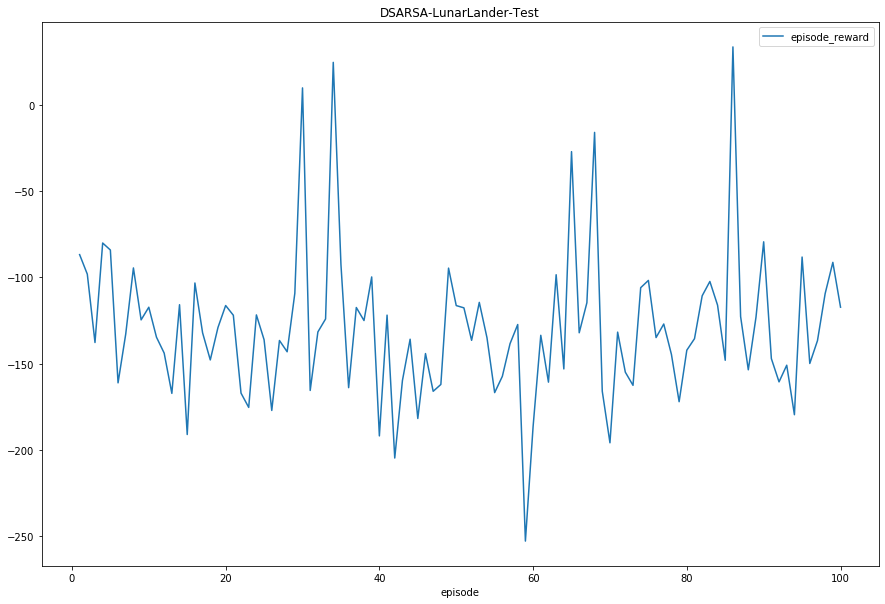

In [18]:
test_df.set_index(['episode'])[['episode_reward']].plot()
plt.title('DSARSA-LunarLander-Test')
plt.savefig(results_save_path+'test_rewards.png', dpi=400, bbox_inches='tight')